# This notebook analyzes FVS benchmark results and produces various graphics

In [1]:
#
# Configure these settings to reflect your local setup
#

DEEP1B_DATASETS= {  \
    "deep1M": { \
        "plottitle": "1M of Deep1B", \
        "queries": { \
            10: "results/benchmarks-%s-q10.csv",\
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        } \
    }, \
    "deep2M": { \
        "plottitle": "2M of Deep1B", \
        "queries": { \
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        } \
    }, \
    "deep5M": {
        "plottitle": "5M of Deep1B",
        "queries": {
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        }
    }, \
    "deep10M": {
        "plottitle": "10M of Deep1B",
        "queries": {
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        }
    }
    
}

NUM_APUS=1 #TODO: We should validate allocation_id

MAIN_MEMORY_SIZE = "700G"


In [2]:
#
# Imports
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#
# Load all the CSV files into a master dataframe
#

all_dfs= []

for dset in DEEP1B_DATASETS.keys():
    for num_queries in DEEP1B_DATASETS[dset]["queries"].keys():
        df = pd.read_csv( DEEP1B_DATASETS[dset]["queries"][num_queries] % dset )
        
        df['dset_name'] = dset
        df['num_queries'] = num_queries
        all_dfs.append( df )


df_all = pd.concat( all_dfs )
print(df_all.shape)
print(df_all.columns)


(180, 14)
Index(['allocationid', 'datasetid', 'dataset_path', 'queries_path', 'bits',
       'ts_start', 'ts_train_start', 'ts_train_end', 'ts_query_start',
       'ts_query_end', 'response', 'recall', 'dset_name', 'num_queries'],
      dtype='object')


In [4]:
#
# Create throughput column
#

df_all['throughput'] = df_all.apply( \
            lambda row: row['num_queries']/row['response'], axis=1 )
    
print(df_all[["dset_name","bits","response","recall", "throughput"]])

   dset_name  bits  response  recall  throughput
0     deep1M   768  0.020478  1.0000  488.334710
1     deep1M   768  0.017423  1.0000  573.953474
2     deep1M   768  0.018164  1.0000  550.533013
3     deep1M   512  0.021775  1.0000  459.249379
4     deep1M   512  0.020864  1.0000  479.303071
..       ...   ...       ...     ...         ...
10   deep10M   128  3.048749  0.9616  328.003381
11   deep10M   128  3.063461  0.9616  326.428155
12   deep10M    64  1.770782  0.8410  564.722345
13   deep10M    64  1.897102  0.8410  527.119710
14   deep10M    64  1.765999  0.8410  566.251828

[180 rows x 5 columns]


In [5]:
# 
# Grouping rows by (num_queries,bits) and then average 'recall' and 'throughput'
# 

df_plot = \
    df_all[["dset_name", "num_queries","bits","recall","throughput"]].\
        groupby(["dset_name",'num_queries', 'bits'], as_index=False).mean()
print(df_plot)

   dset_name  num_queries  bits  recall   throughput
0    deep10M           10    64  0.9100   485.333260
1    deep10M           10   128  0.9900   425.420172
2    deep10M           10   256  0.9900   358.927548
3    deep10M           10   512  1.0000   226.714040
4    deep10M           10   768  1.0000   151.806532
5    deep10M          100    64  0.8420   635.544865
6    deep10M          100   128  0.9680   506.325562
7    deep10M          100   256  0.9950   493.916594
8    deep10M          100   512  1.0000   134.937488
9    deep10M          100   768  1.0000   116.249572
10   deep10M         1000    64  0.8410   552.697961
11   deep10M         1000   128  0.9616   327.364690
12   deep10M         1000   256  0.9934   323.188325
13   deep10M         1000   512  0.9984   237.690891
14   deep10M         1000   768  0.9985   184.281293
15    deep1M           10    64  0.9700  1332.205698
16    deep1M           10   128  0.9800   927.241780
17    deep1M           10   256  1.0000   948.

In [6]:
# get min and max error bars for throughput

aggs = df_all[["dset_name", "num_queries","bits","recall","throughput"]].\
        groupby(["dset_name",'num_queries', 'bits'], as_index=False).\
                agg({'throughput': [('min_error', lambda x: x.mean() - x.min()), ('max_error', lambda x: x.max() - x.mean())]})

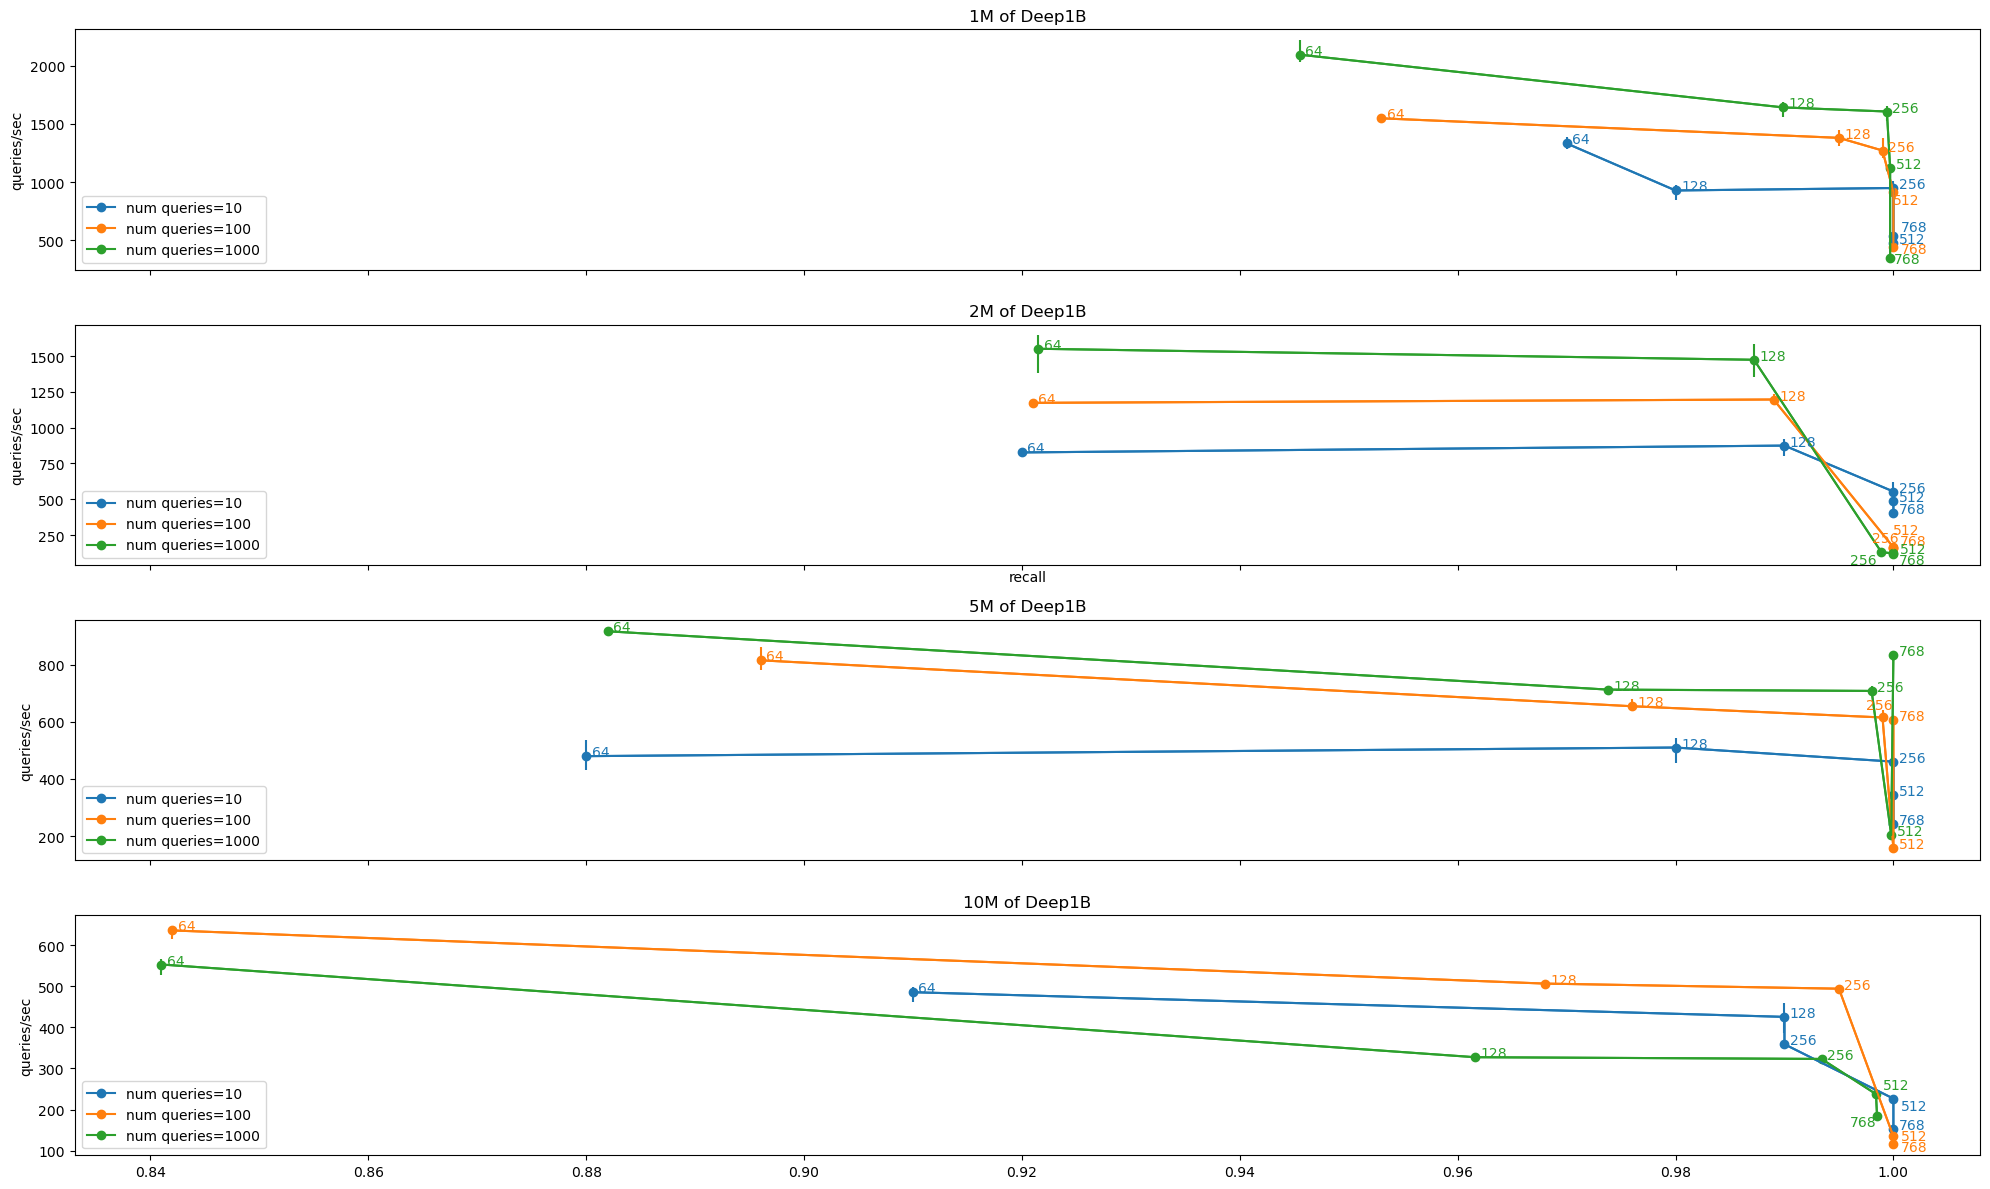

In [19]:
# 
# Plot the data
# 
num_plots = len( DEEP1B_DATASETS.keys() )

fig, axs = plt.subplots(num_plots, sharex=True, figsize=(20,12))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
for d, dset in enumerate(DEEP1B_DATASETS.keys()):
    for q, num_queries in enumerate(DEEP1B_DATASETS[dset]["queries"]):
        y_errormin = aggs.loc[ \
            (aggs['dset_name']==dset) & \
            (aggs['num_queries'] == num_queries)].\
                throughput['min_error']
        y_errormax = aggs.loc[ \
            (aggs['dset_name']==dset) & \
            (aggs['num_queries'] == num_queries)].\
                throughput['max_error']
        y_error = [y_errormin, y_errormax]
        recalls = df_plot.loc[ \
                (df_plot['dset_name']==dset) & \
                (df_plot['num_queries']==num_queries)\
                ]["recall"]
        throughputs = df_plot.loc[ \
                (df_plot['dset_name']==dset) & \
                (df_plot['num_queries']==num_queries)\
                ]["throughput"]
        bits = df_plot.loc[ \
            (df_plot['dset_name']==dset) & \
            (df_plot['num_queries']==num_queries)\
            ]["bits"]
        for i in bits.index: # text for bits, added .0005 for readability
            axs[d].text(recalls[i]+.0005, throughputs[i], bits[i], color=colors[q])
        axs[d].errorbar(recalls, throughputs, yerr=y_error)
        axs[d].plot( recalls, throughputs, '-o',label="num queries=%d" % num_queries, color=colors[q])
        axs[d].set_title( DEEP1B_DATASETS[dset]["plottitle"] )
        axs[d].set_ylabel("queries/sec")
        if d==len(DEEP1B_DATASETS[dset].keys())-1:
            axs[d].set_xlabel("recall")
        axs[d].legend(loc='lower left')

# 1M
axs[0].texts[4].set_position((1.0007, 575.0)) #blue 768
axs[0].texts[8].set_position((1.0, 813.0)) #orange 512
axs[0].texts[9].set_position((1.0007, 390.0)) #orange 768
axs[0].texts[14].set_position((1.0, 300.0)) #green 768
# 2M
axs[1].texts[7].set_position((0.998, 200.0)) #orange 256
axs[1].texts[8].set_position((0.99995, 259)) #orage 512
axs[1].texts[9].set_position((1.0006, 180.0)) #orange 765
axs[1].texts[12].set_position((0.996, 50.0)) #green 256
axs[1].texts[13].set_position((1.0006, 125.0)) #green 512
axs[1].texts[14].set_position((1.0005, 50.0)) #green 768
# 5M
axs[2].texts[7].set_position((0.9975, 645.0)) #orange 256
# 10M
axs[3].texts[3].set_position((1.0007, 200))
axs[3].texts[8].set_position((1.0007, 125)) #orange 512
axs[3].texts[9].set_position((1.0007, 100)) #orange 768
axs[3].texts[13].set_position((0.999, 250)) #green 512
axs[3].texts[14].set_position((0.996, 160)) #green 768
plt.tight_layout()
plt.savefig("results/gemini_fvs_deep1B.png")